# Divide data into training and validation

In [10]:
from PIL import Image
import glob
import shutil
import os
path_masks = "../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/"
path_lungs =  "../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/"
i = 0
for data_type in ["train", "val"]:
    os.makedirs(data_type + "/images",exist_ok=True)
    os.makedirs(data_type + "/masks",exist_ok=True)
for image_path in glob.glob("../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/*.png"):
    image_name = image_path.split('/')[-1]
    image_mask_path = path_masks + image_name.split('.')[0] + "_mask.png"
    if os.path.exists(image_mask_path):
        if i % 5 == 0:
            shutil.copy(image_mask_path, "val/masks")
            shutil.copy(image_path, "val/images")
        else:
            shutil.copy(image_mask_path, "train/masks")
            shutil.copy(image_path, "train/images")
        i+=1
print(i, "images were copied succesfully ")

566 images were copied succesfully 


# Creating class for loading data

In [11]:
import torch
import torchvision

class LungDataset(torch.utils.data.Dataset):
    def __init__(self,root,transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root, "images", self.imgs[index])
        mask_path = os.path.join(self.root, "masks", self.masks[index])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            mask = torch.round(mask)
        return img, mask
    def __len__(self):
        return len(self.imgs)

In [12]:
import torch
import torchvision
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

train_dataset = LungDataset('train', train_transforms)
val_dataset = LungDataset('val', train_transforms)

In [13]:
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True, num_workers = batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle = False, num_workers = batch_size)

# Data vizualization

In [14]:
import matplotlib.pyplot as plt
def show_tensorImage(tensorImage, title = ''):
    if tensorImage.shape[0] == 1:
        tensorImage.squeeze_(0)
    else:
        tensorImage = tensorImage.permute(1,2,0)
    image = tensorImage.numpy()
    plt.imshow(image)
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [15]:
X, Y = next(iter(train_dataloader))

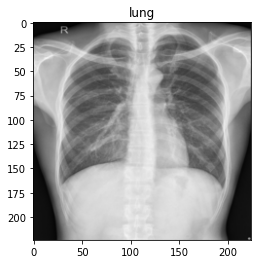

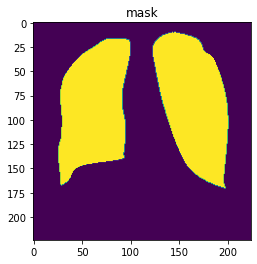

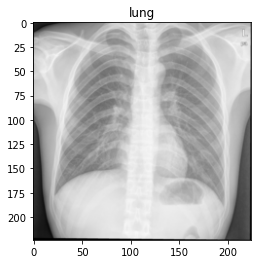

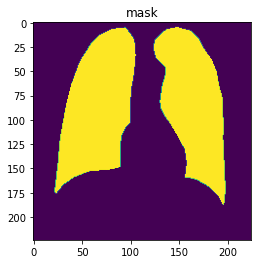

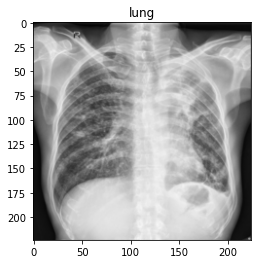

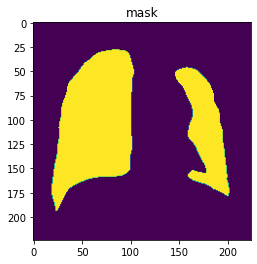

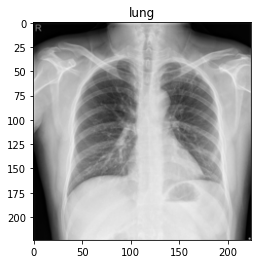

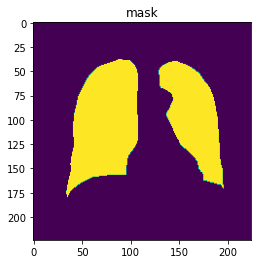

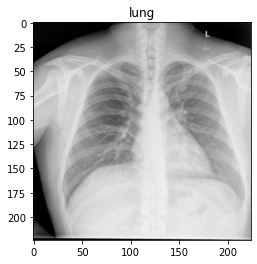

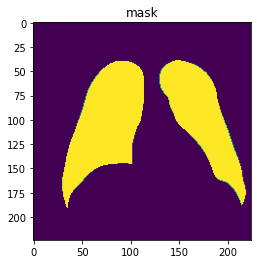

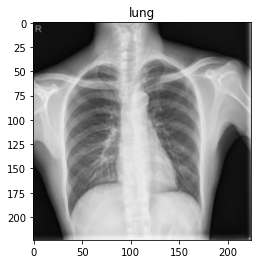

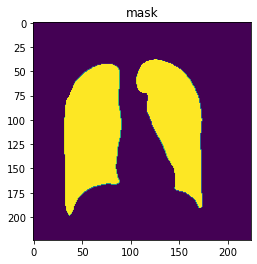

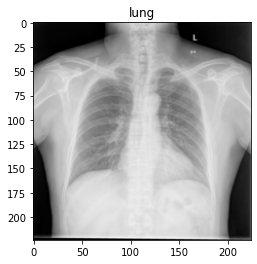

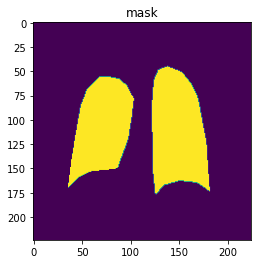

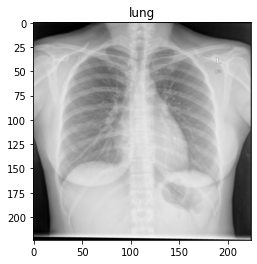

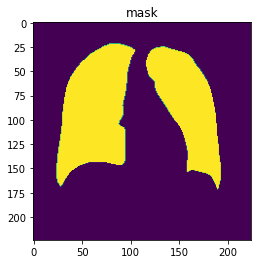

In [16]:
for x, y in zip(X,Y):
    show_tensorImage(x, title='lung')
    show_tensorImage(y, title='mask')

# Creating model

In [17]:
class SegmentModel(torch.nn.Module):
    def __init__(self):
        super(SegmentModel, self).__init__()
        self.downSampling = torchvision.models.alexnet(pretrained=True).features
        for param in self.downSampling.parameters():
            param.requires_grad = False
        self.upSampling = torch.nn.Sequential(
            torch.nn.Conv2d(256,128,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,64,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.ReLU(),  
            torch.nn.UpsamplingNearest2d((50,50)),
            torch.nn.Conv2d(64,32,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32,16,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.UpsamplingNearest2d((100,100)), 
            torch.nn.Conv2d(16,8,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8,4,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.ReLU(), 
            torch.nn.UpsamplingNearest2d((224,224)),
            torch.nn.Conv2d(4,2,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(2,1,kernel_size=(3,3),stride=1,padding=(1,1)),
            torch.nn.Sigmoid()
      )

    def forward(self, x):
        for layer in self.downSampling:
            x = layer(x)

        for layer in self.upSampling:
            x = layer(x)
        return x

In [18]:
model = SegmentModel()

In [19]:
loss = torch.nn.BCELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Training

In [20]:
def train_model(model, num_epochs, loss, optim, device):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.

            # Iterate over data.
            for inputs, masks in (dataloader):
                inputs = inputs.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, masks)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()

            epoch_loss = running_loss / len(dataloader)

            print(phase + ' loss = ', epoch_loss)

    return model

In [21]:
model = train_model(model, 100, loss, optimizer, device)

Epoch 0/99:
train loss =  0.7178913407158434
val loss =  0.6692359129587809
Epoch 1/99:
train loss =  0.6424761832806102
val loss =  0.6150153438250224
Epoch 2/99:
train loss =  0.6007618799544218
val loss =  0.5834328174591065
Epoch 3/99:
train loss =  0.5734752782604151
val loss =  0.5643893480300903
Epoch 4/99:
train loss =  0.5510807392889994
val loss =  0.5401428461074829
Epoch 5/99:
train loss =  0.5286947697923895
val loss =  0.5208389123280843
Epoch 6/99:
train loss =  0.5079527957397595
val loss =  0.500027718146642
Epoch 7/99:
train loss =  0.4887914814447102
val loss =  0.48274362881978355
Epoch 8/99:
train loss =  0.4709722519966594
val loss =  0.46811089714368187
Epoch 9/99:
train loss =  0.45424545229526986
val loss =  0.45052560170491535
Epoch 10/99:
train loss =  0.43717912728326364
val loss =  0.4382516324520111
Epoch 11/99:
train loss =  0.422099033468648
val loss =  0.4227205117543538
Epoch 12/99:
train loss =  0.4084159235159556
val loss =  0.408711302280426
Epoch 1

KeyboardInterrupt: 

# Result vizualization

Lung


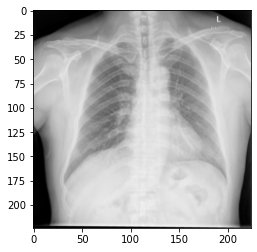

Mask


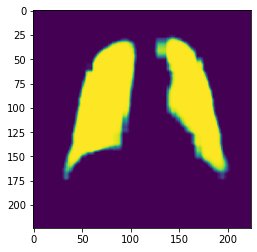

Lung


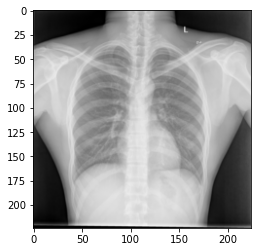

Mask


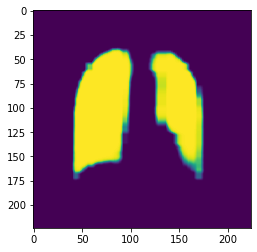

Lung


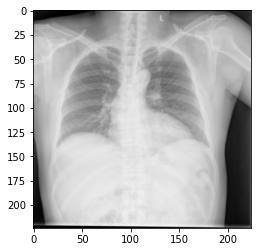

Mask


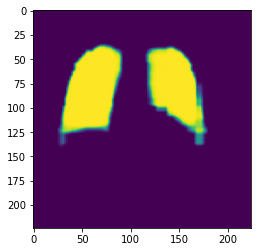

Lung


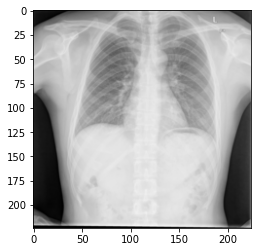

Mask


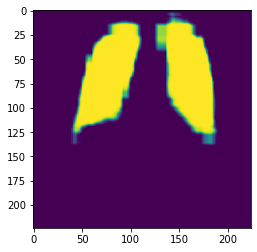

Lung


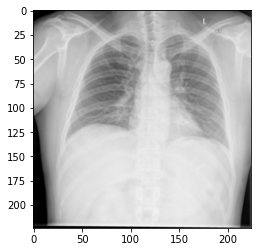

Mask


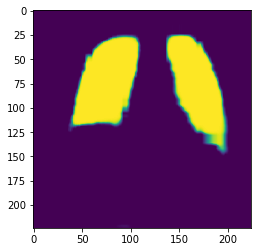

Lung


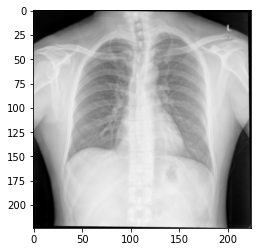

Mask


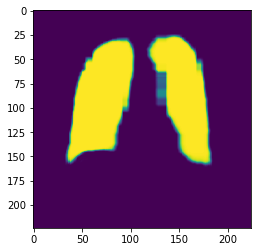

Lung


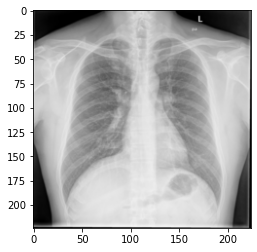

Mask


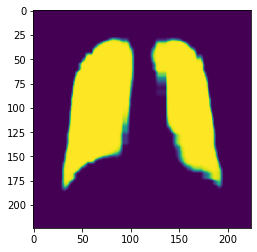

Lung


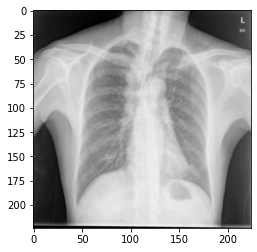

Mask


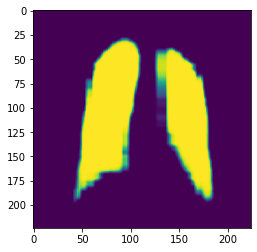

In [28]:
X, Y = next(iter(val_dataloader))
x = X[0]
pred = model(x.unsqueeze(0).to(device))
pred = pred.detach()
for i in range(8):
    x = X[i]
    pred = model(x.unsqueeze(0).to(device))
    pred = pred.detach()
    show_tensorImage(x,'Lung')
    show_tensorImage(pred.squeeze(0).cpu(),'Mask')